In [1]:
from PIL import Image
import numpy as np
import scipy.stats
import tarfile

# 下載 dataset
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
import os
import urllib
from urllib.request import urlretrieve
def reporthook(a,b,c):
    print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
tar_gz = "cifar-10-python.tar.gz"
if not os.path.isfile(tar_gz):
        print('Downloading data from %s' % url)
        urlretrieve(url, tar_gz, reporthook=reporthook)

import pickle
train_X=[]
train_y=[]
tar_gz = "cifar-10-python.tar.gz"
with tarfile.open(tar_gz) as tarf:
    for i in range(1, 6):
        dataset = "cifar-10-batches-py/data_batch_%d"%i
        print("load",dataset)
        with tarf.extractfile(dataset) as f:
            result = pickle.load(f, encoding='latin1')
        train_X.extend( np.moveaxis(result['data'].reshape(-1,3,32,32),1,3)/255*2-1)
        train_y.extend(result['labels'])
    train_X=np.float32(train_X)
    train_y=np.int32(train_y)
    dataset = "cifar-10-batches-py/test_batch"
    print("load",dataset)
    with tarf.extractfile(dataset) as f:
        result = pickle.load(f, encoding='latin1')
        test_X=np.float32(np.moveaxis(result['data'].reshape(-1,3,32,32),1,3)/255*2-1)
        test_y=np.int32(result['labels'])
        

load cifar-10-batches-py/data_batch_1
load cifar-10-batches-py/data_batch_2
load cifar-10-batches-py/data_batch_3
load cifar-10-batches-py/data_batch_4
load cifar-10-batches-py/data_batch_5
load cifar-10-batches-py/test_batch


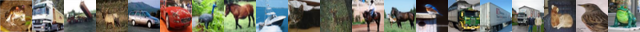

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
['青蛙' '卡車' '卡車' '鹿' '汽車' '汽車' '鳥' '馬' '船' '貓' '鹿' '馬' '馬' '鳥' '卡車' '卡車'
 '卡車' '貓' '鳥' '青蛙']


In [3]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    # N*3072 -> N*3*32*32 -> 32 * 32N * 3
    #int_X_reshape = np.moveaxis(int_X.reshape(-1,3,32,32), 1, 3)
    int_X_reshape = int_X.reshape(rows, -1, 32, 32,3).swapaxes(1,2).reshape(rows*32,-1, 3)
    display(Image.fromarray(int_X_reshape))
# 訓練資料， X 的前 20 筆
showX(train_X[:20])
print(train_y[:20])
name_array = np.array("飛機、汽車、鳥、貓、鹿、狗、青蛙、馬、船、卡車".split('、'))
print(name_array[train_y[:20]])

In [4]:
import torch
import torch.nn as nn

In [5]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu, n_extra_layers=0):
        super(DCGAN_D, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial.conv.{0}-{1}'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial.relu.{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cndf),
                            nn.BatchNorm2d(cndf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid.{0}-{1}.conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid.{0}.relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        main.add_module('final.{0}-{1}.conv'.format(cndf, 1),
                        nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))
        self.main = main


    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
            
        output = output.mean(0)
        return output.view(1)
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu, n_extra_layers=0):
        super(DCGAN_G, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.Sequential()
        # input is Z, going into a convolution
        main.add_module('initial.{0}-{1}.convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial.{0}.batchnorm'.format(cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('initial.{0}.relu'.format(cngf),
                        nn.ReLU(True))

        csize, cndf = 4, cngf
        while csize < isize//2:
            main.add_module('pyramid.{0}-{1}.convt'.format(cngf, cngf//2),
                            nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.batchnorm'.format(cngf//2),
                            nn.BatchNorm2d(cngf//2))
            main.add_module('pyramid.{0}.relu'.format(cngf//2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cngf),
                            nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.batchnorm'.format(t, cngf),
                            nn.BatchNorm2d(cngf))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cngf),
                            nn.ReLU(True))

        main.add_module('final.{0}-{1}.convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final.{0}.tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
        return output 

In [6]:
class DCGAN_D_nobn(nn.Module):
    def __init__(self, isize, nz, nc, ndf, ngpu, n_extra_layers=0):
        super(DCGAN_D_nobn, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        # input is nc x isize x isize
        main.add_module('initial.conv.{0}-{1}'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial.relu.{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=True))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid.{0}-{1}.conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=True))
            main.add_module('pyramid.{0}.relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        main.add_module('final.{0}-{1}.conv'.format(cndf, 1),
                        nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))
        self.main = main


    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else: 
            output = self.main(input)
            
        output = output.mean(0)
        return output.view(1)

class DCGAN_G_nobn(nn.Module):
    def __init__(self, isize, nz, nc, ngf, ngpu, n_extra_layers=0):
        super(DCGAN_G_nobn, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.Sequential()
        main.add_module('initial.{0}-{1}.convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial.{0}.relu'.format(cngf),
                        nn.ReLU(True))

        csize, cndf = 4, cngf
        while csize < isize//2:
            main.add_module('pyramid.{0}-{1}.convt'.format(cngf, cngf//2),
                            nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
            main.add_module('pyramid.{0}.relu'.format(cngf//2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}.{1}.conv'.format(t, cngf),
                            nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}.{1}.relu'.format(t, cngf),
                            nn.ReLU(True))

        main.add_module('final.{0}-{1}.convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final.{0}.tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input,  range(self.ngpu))
        else: 
            output = self.main(input)
        return output 

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
nc = 3
nz = 100
ngf = 64
ndf = 64
n_extra_layers = 0
Diters = 5

imageSize = 32
batchSize = 64
lrD = 0.00005
lrG = 0.00005
clamp_lower, clamp_upper = -0.01, 0.01

In [9]:
netG = DCGAN_G_nobn(imageSize, nz, nc, ngf, 1, n_extra_layers)
netG.apply(weights_init)

DCGAN_G_nobn (
  (main): Sequential (
    (initial.100-256.convt): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial.256.relu): ReLU (inplace)
    (pyramid.256-128.convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.128.relu): ReLU (inplace)
    (pyramid.128-64.convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.64.relu): ReLU (inplace)
    (final.64-3.convt): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (final.3.tanh): Tanh ()
  )
)

In [10]:
netD = DCGAN_D(imageSize, nz, nc, ndf, 1, n_extra_layers)
netD.apply(weights_init)

DCGAN_D (
  (main): Sequential (
    (initial.conv.3-64): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (initial.relu.64): LeakyReLU (0.2, inplace)
    (pyramid.64-128.conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.128.batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.128.relu): LeakyReLU (0.2, inplace)
    (pyramid.128-256.conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.256.batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (pyramid.256.relu): LeakyReLU (0.2, inplace)
    (final.256-1.conv): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [11]:
netG

DCGAN_G_nobn (
  (main): Sequential (
    (initial.100-256.convt): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial.256.relu): ReLU (inplace)
    (pyramid.256-128.convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.128.relu): ReLU (inplace)
    (pyramid.128-64.convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid.64.relu): ReLU (inplace)
    (final.64-3.convt): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (final.3.tanh): Tanh ()
  )
)

In [12]:
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
one = torch.FloatTensor([1])
mone = one * -1

In [16]:
netD.cuda()
netG.cuda()
input = input.cuda()
one, mone = one.cuda(), mone.cuda()
noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

In [14]:
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [16]:
optimizerD = optim.RMSprop(netD.parameters(), lr = lrD)
optimizerG = optim.RMSprop(netG.parameters(), lr = lrG)

[6/1000][120/781][500] Loss_D: -0.643956 Loss_G: 0.316144 Loss_D_real: -0.330755 Loss_D_fake 0.313201 74.17012023925781


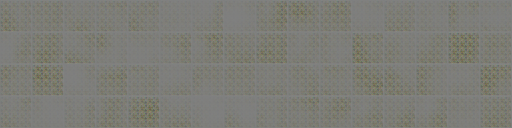

[9/1000][360/781][1000] Loss_D: -0.659229 Loss_G: 0.331399 Loss_D_real: -0.331422 Loss_D_fake 0.327807 117.946044921875


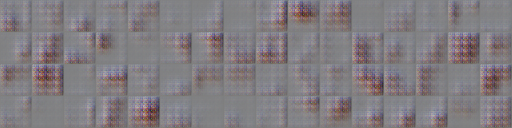

[12/1000][600/781][1500] Loss_D: -0.618801 Loss_G: 0.323879 Loss_D_real: -0.297496 Loss_D_fake 0.321304 160.01616382598877


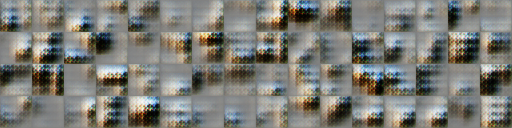

[16/1000][55/781][2000] Loss_D: -0.573489 Loss_G: 0.298747 Loss_D_real: -0.271258 Loss_D_fake 0.302231 204.68532800674438


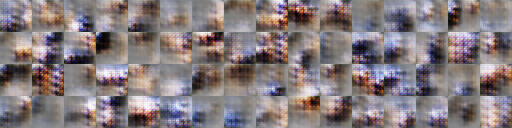

[19/1000][295/781][2500] Loss_D: -0.577532 Loss_G: 0.312225 Loss_D_real: -0.277837 Loss_D_fake 0.299695 246.67952489852905


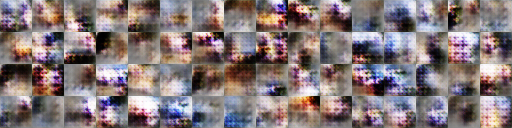

[22/1000][535/781][3000] Loss_D: -0.535316 Loss_G: 0.295750 Loss_D_real: -0.254215 Loss_D_fake 0.281101 289.54344034194946


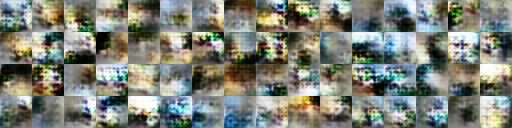

[25/1000][775/781][3500] Loss_D: -0.506160 Loss_G: 0.274308 Loss_D_real: -0.234952 Loss_D_fake 0.271208 331.8595016002655


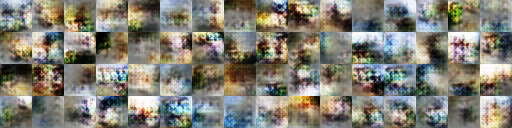

[29/1000][140/781][4000] Loss_D: -0.494719 Loss_G: 0.266077 Loss_D_real: -0.227697 Loss_D_fake 0.267021 372.2169315814972


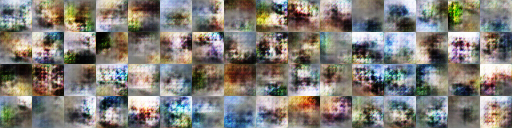

[32/1000][380/781][4500] Loss_D: -0.452797 Loss_G: 0.249800 Loss_D_real: -0.197354 Loss_D_fake 0.255442 414.2712314128876


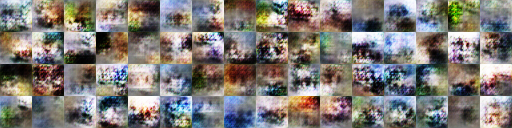

[35/1000][620/781][5000] Loss_D: -0.422235 Loss_G: 0.252897 Loss_D_real: -0.218968 Loss_D_fake 0.203267 456.8509817123413


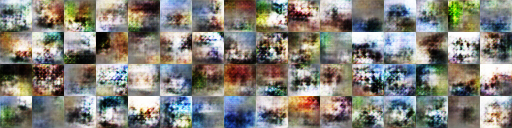

KeyboardInterrupt: 

In [17]:
import time
t0 = time.time()
niter = 1000
gen_iterations = 0
for epoch in range(niter):
    i = 0
    batches = train_X.shape[0]//batchSize
    while i < batches:
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update
        if gen_iterations < 25 or gen_iterations %500 == 0:
            _Diters = 100
        else:
            _Diters = Diters
        j = 0
        while j < _Diters and i < batches:
            j+=1
            
            # clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
                
            real_data = torch.from_numpy(
                np.moveaxis(train_X[i*batchSize:(i+1)*batchSize], 3,1)
            ).cuda()
            i+=1
            
            netD.zero_grad()
            input.resize_as_(real_data).copy_(real_data)
            inputv = Variable(input)
            
            errD_real = netD(inputv)
            errD_real.backward(one)
            
            # train with fake
            noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
            noisev = Variable(noise, volatile = True) # totally freeze netG
            fake = Variable(netG(noisev).data)
            inputv = fake
            errD_fake = netD(inputv)
            errD_fake.backward(mone)
            errD = errD_real - errD_fake
            optimizerD.step()

        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        errG = netD(fake)
        errG.backward(one)
        optimizerG.step()
        gen_iterations += 1
        if gen_iterations%500 ==0:
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, niter, i, batches, gen_iterations,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]), time.time()-t0)
        if gen_iterations%500 == 0:            
            fake = netG(Variable(fixed_noise, volatile=True))            
            showX(np.moveaxis(fake.data.cpu().numpy(),1,3), 4)
        

-------------------------